In [5]:
# --- Install & Load Libraries ---
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip



replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
replace CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [9]:
# ===============================================
# 1. Load the raw images and their captions
# ===============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
#from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import tensorflow as tf
from tensorflow.keras import layers

# Load captions file
def load_captions(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Create a mapping from image ID to list of captions
def create_mapping(doc):
    mapping = {}
    for line in doc.strip().split('\n'):
        tokens = line.split('\t')
        if len(tokens) != 2:
            continue
        image_id, caption = tokens
        image_id = image_id.split('.')[0]  # remove filename extension
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(caption)
    return mapping

# Dataset paths
captions_file = '/kaggle/working/Flickr8k.token.txt'
dataset_dir = '/kaggle/working/Flicker8k_Dataset'

captions_doc = load_captions(captions_file)
captions_mapping = create_mapping(captions_doc)




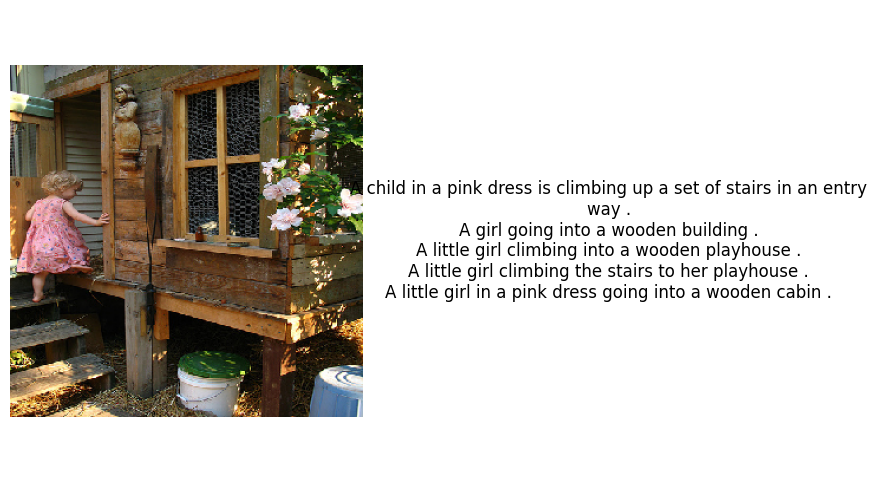

Sample Image ID: 1000268201_693b08cb0e
Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [10]:
# Display the sample image and its captions
sample_image_id = list(captions_mapping.keys())[0]  # Get the first image ID
sample_captions = captions_mapping[sample_image_id]  # Get the captions for that image

# Load the image
sample_image_path = os.path.join(dataset_dir, sample_image_id + '.jpg')
sample_image = load_img(sample_image_path, target_size=(299, 299))  # Resize for VGG16
sample_image_array = img_to_array(sample_image)
sample_image_array = preprocess_input(sample_image_array)

# Plot the image and captions
plt.figure(figsize=(10, 6))

# Show the image
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.axis('off')  # Hide axes for better display

# Show the captions
plt.subplot(1, 2, 2)
plt.text(0.5, 0.5, '\n'.join(sample_captions), fontsize=12, ha='center', va='center', wrap=True)
plt.axis('off')  # Hide axes for better display

plt.show()

print(f"Sample Image ID: {sample_image_id}")
print(f"Captions: {sample_captions}")


In [17]:
# ===============================================
# 1. Load VGG16 model (without classifier layers)
# ===============================================
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

# Load VGG16 model (without classifier layers)
vgg_model = VGG16(weights='imagenet')
feature_extractor = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

# ===============================================
# 2. Function to preprocess and extract features in batches
# ===============================================
def extract_features_batch(image_paths):
    batch = []
    for img_path in image_paths:
        try:
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)
            batch.append(img)
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            continue  # Skip missing image files
    
    if not batch:
        return np.array([])  # Return empty array if no images were successfully loaded
    
    # Convert list of images into a numpy array
    batch = np.vstack(batch)
    
    # Get features for the batch
    features = feature_extractor.predict(batch, verbose=0)
    return features

# ===============================================
# 3. Extract features for images in batches
# ===============================================
# Define a batch size
batch_size = 32  # You can adjust this based on your memory capacity

# Create batches of image paths
image_features = {}
all_image_ids = list(captions_mapping.keys())

# Create list of image paths
image_paths_batch = [os.path.join(dataset_dir, image_id + '.jpg') for image_id in all_image_ids]
batch_start = 0

while batch_start < len(image_paths_batch):
    batch_end = min(batch_start + batch_size, len(image_paths_batch))
    image_paths_batch_current = image_paths_batch[batch_start:batch_end]
    
    features_batch = extract_features_batch(image_paths_batch_current)
    
    # Only store features if they were successfully extracted
    if features_batch.size > 0:
        for idx, image_id in enumerate(all_image_ids[batch_start:batch_end]):
            if image_paths_batch[idx] in image_paths_batch_current:  # Ensure correct matching
                image_features[image_id] = features_batch[idx]
    
    # Update the start index for the next batch
    batch_start = batch_end
    print(f"Processed batch {batch_start // batch_size + 1}/{len(image_paths_batch) // batch_size + 1}")

# Now `image_features` will contain feature vectors for all images in the dataset


I0000 00:00:1745784557.356697      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745784557.357392      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


I0000 00:00:1745784564.861201     108 service.cc:148] XLA service 0x7c73581090f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745784564.863146     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745784564.863172     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745784565.068569     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745784575.692955     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Processed batch 2/253
Processed batch 3/253
Processed batch 4/253
Processed batch 5/253
Processed batch 6/253
Processed batch 7/253
Processed batch 8/253
Processed batch 9/253
Processed batch 10/253
Processed batch 11/253
Processed batch 12/253
Processed batch 13/253
Processed batch 14/253
Processed batch 15/253
Processed batch 16/253
Processed batch 17/253
Processed batch 18/253
Processed batch 19/253
Processed batch 20/253
Processed batch 21/253
Processed batch 22/253
Processed batch 23/253
Processed batch 24/253
Processed batch 25/253
Processed batch 26/253
Processed batch 27/253
Processed batch 28/253
Processed batch 29/253
Processed batch 30/253
Processed batch 31/253
Processed batch 32/253
Processed batch 33/253
Processed batch 34/253
Processed batch 35/253
Processed batch 36/253
Processed batch 37/253
Processed batch 38/253
Processed batch 39/253
Processed batch 40/253
Processed batch 41/253
Processed batch 42/253
Processed batch 43/253
File not found: /kaggle/working/Flicker8k_

In [18]:
# ===============================================
# 3. Perform necessary text preprocessing
# ===============================================

import re

# Clean captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = re.sub(r'[^a-z]', ' ', caption)
            caption = re.sub(r'\s+', ' ', caption)
            caption = 'startseq ' + caption.strip() + ' endseq'
            captions[i] = caption

# Apply cleaning
clean(captions_mapping)

# Gather all captions
all_captions = []
for captions in captions_mapping.values():
    all_captions.extend(captions)

# Tokenize captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary Size: {vocab_size}')

# Maximum caption length
max_length = max(len(caption.split()) for caption in all_captions)
print(f'Max Caption Length: {max_length}')



Vocabulary Size: 8444
Max Caption Length: 38


In [20]:
# ===============================================
# 4. Dataset preparation (features + captions) 
# ===============================================

# Tokenizer and other pre-requisites (to be defined before this part of the code)
# Initialize the tokenizer and fit it on the captions
tokenizer = Tokenizer()
all_captions = []
for key in captions_mapping:
    all_captions.extend(captions_mapping[key])  # Add all captions to a single list
tokenizer.fit_on_texts(all_captions)

# Define the vocab size and maximum sequence length
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
max_length = max([len(caption.split()) for caption in all_captions])  # Maximum length of captions

def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = [], [], []
    for key, desc_list in descriptions.items():
        # Only process image IDs that have features
        if key not in photos:
            continue
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]  # Convert caption to sequence of integers
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  # Padding input sequence
                out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]  # One-hot encode output
                X1.append(photos[key])  # Corresponding image feature
                X2.append(in_seq)      # Input sequence (caption part)
                y.append(out_seq)      # Output sequence (next word in caption)
    return np.array(X1), np.array(X2), np.array(y)

# Prepare input and output sequences
X1, X2, y = create_sequences(tokenizer, max_length, captions_mapping, image_features)

# Split into training and testing
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)


In [24]:
from tensorflow.keras import layers, models

# Define the captioning model
input1 = layers.Input(shape=(4096,))  # Image feature vector (VGG16 output size: 4096)
input2 = layers.Input(shape=(max_length,))  # Input sequence (caption part)

# Encoder: process the image features
fc1 = layers.Dense(256, activation='relu')(input1)
encoded_image = layers.RepeatVector(max_length)(fc1)  # Repeat the image feature vector for the length of the caption sequence

# Decoder: process the caption sequence
embedding = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length)(input2)
gru = layers.GRU(256, return_sequences=True)(embedding)

# Attention Mechanism (optional)
# attention = layers.Attention()([gru, encoded_image])

# Concatenate the encoded image and GRU output
decoder_input = layers.concatenate([encoded_image, gru])

# Process the concatenated input
gru_output = layers.GRU(256)(decoder_input)
output = layers.Dense(vocab_size, activation='softmax')(gru_output)

# Define the model
model = models.Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 38)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │      1,048,832 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 38, 256)        │      2,161,664 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 38, 256)        │              0 │ dense_4[0][0]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 38, 256)        │        394,752 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 38, 512)        │              0 │ repeat_vector[0][0],   │
│                           │                        │                │ gru_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ (None, 256)            │        591,360 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8444)           │      2,170,108 │ gru_2[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,366,716 (24.29 MB)

 Trainable params: 6,366,716 (24.29 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# ===============================================
# 6. Train the model
# ===============================================
history = model.fit([X1_train, X2_train], y_train, 
                    epochs=20,  # Adjust the number of epochs as needed
                    batch_size=64,  # You can adjust the batch size as well
                    validation_data=([X1_test, X2_test], y_test))

# Optionally save the model
# model.save('image_captioning_model.h5')


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.0712 - loss: 7.6061 - val_accuracy: 0.1294 - val_loss: 5.7751
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1392 - loss: 4.8267 - val_accuracy: 0.1294 - val_loss: 5.7001
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1423 - loss: 4.6029 - val_accuracy: 0.1418 - val_loss: 5.6944
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1511 - loss: 4.6264 - val_accuracy: 0.1294 - val_loss: 5.6678
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1501 - loss: 4.4154 - val_accuracy: 0.1393 - val_loss: 5.6304
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1464 - loss: 4.4461 - val_accuracy: 0.1493 - val_loss: 5.5472
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1782 - loss: 4.2748 - val_accuracy: 0.1493 - val_loss: 5.4526
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2017 - loss: 4.0572 - val_accuracy: 0.1592 - v

In [26]:
# ===============================================
# 7. Inference: generate captions for new images
# ===============================================

def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = None
        for w, index in tokenizer.word_index.items():
            if index == yhat:
                word = w
                break
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text
